# Trigram py-torch-ify model

In [1]:
# build training data set

In [2]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()
vocabs = sorted(set(list(''.join(words)))) + ['.']
itoc = dict(enumerate(vocabs))
ctoi = {v:k for k,v in itoc.items()}
itoc[0], ctoi['a']
block_size = 3

In [4]:
# build training data set
def build_dataset(words):
    random.shuffle(words)
    X, Y = [], []
    for w in words:
        w = list(w) + ['.']
        context = [ctoi['.']] * block_size
        for y in w:
            X.append(context)
            Y.append(ctoi[y])
            context = context[1: ] + [ctoi[y]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words)
n1 = int(X.shape[0] * 0.8) 
n2 = int(X.shape[0] * 0.9)
Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xtest, Ytest = X[n2:], Y[n2:]

In [5]:
# build Linear and Tanh and BatchNorm class
class Linear():
    def __init__(self, fan_in, fan_out, bias=None):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.randn((fan_out)) * 0.0 if bias else None
        if bias == True:
            self.bias = torch.randn((fan_out)) * 0.0
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias != None: self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + [self.bias] if self.bias != None else [self.weight]

class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class BatchNorm():
    def __init__(self, size, eps=10**-5):
        self.training = True
        self.running_mean = torch.ones((1, size))
        self.running_var = torch.zeros((1, size))
        self.bn_shift = torch.ones((1, size))
        self.bn_bias = torch.zeros((1, size))
        self.eps = eps
    def __call__(self, x):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, keepdim=True)
            self.running_mean = 0.999 * self.running_mean + 0.001 * mean
            self.running_var = 0.999 * self.running_var + 0.001 * var
        else:
            with torch.no_grad():
                mean = self.running_mean
                var = self.running_var
        self.out = self.bn_shift * (x - mean)/torch.sqrt(var + self.eps) + self.bn_bias
        return self.out
    def parameters(self):
        return [self.bn_shift, self.bn_bias]

In [6]:
emb_dim = 10
h_dim = 100
n_word = 27 #len(vocabs) # 27

lockup_table = torch.randn((n_word, emb_dim))

layers = [Linear(emb_dim * block_size, h_dim), BatchNorm(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm(h_dim), Tanh(),
          Linear(h_dim, n_word, bias=True)]
with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight = layer.weight * 5/3
    parameters = [lockup_table] + [p for layer in layers for p in layer.parameters()]
    for p in parameters: p.requires_grad = True
    print(sum([p.nelement() for p in parameters]))

46997


In [7]:
max_steps = 200000
batch_size = 32
lossi = []
ratios = []
for i in range(max_steps):
    # forward
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    x = lockup_table[Xtr[ix]].view((-1, emb_dim * block_size))
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Ytr[ix])
    lossi.append(loss.log10().item())
    # backward
    for l in layers: l.out.retain_grad()
    for p in parameters: p.grad = None
    loss.backward()
    lr = 0.1 if i < (max_steps/2) else 0.01
    for p in parameters: p.data += - lr * p.grad
    with torch.no_grad():
        ratios.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    #track stats
    if i%1000==0:
        print(i, loss.item())
    if i > 10000:
        break
#     break

0 3.292306661605835
1000 2.781280279159546
2000 2.597292423248291
3000 2.1857786178588867
4000 2.928767204284668
5000 2.3085362911224365
6000 2.0611870288848877
7000 2.075582981109619
8000 2.575498104095459
9000 2.004298210144043
10000 2.095548152923584


Layer 2, mean 0.0, std : 0.63, saturated : 4.53%
Layer 5, mean 0.0, std : 0.65, saturated : 5.69%
Layer 8, mean 0.0, std : 0.66, saturated : 4.19%
Layer 11, mean 0.0, std : 0.68, saturated : 3.59%
Layer 14, mean 0.0, std : 0.66, saturated : 1.94%


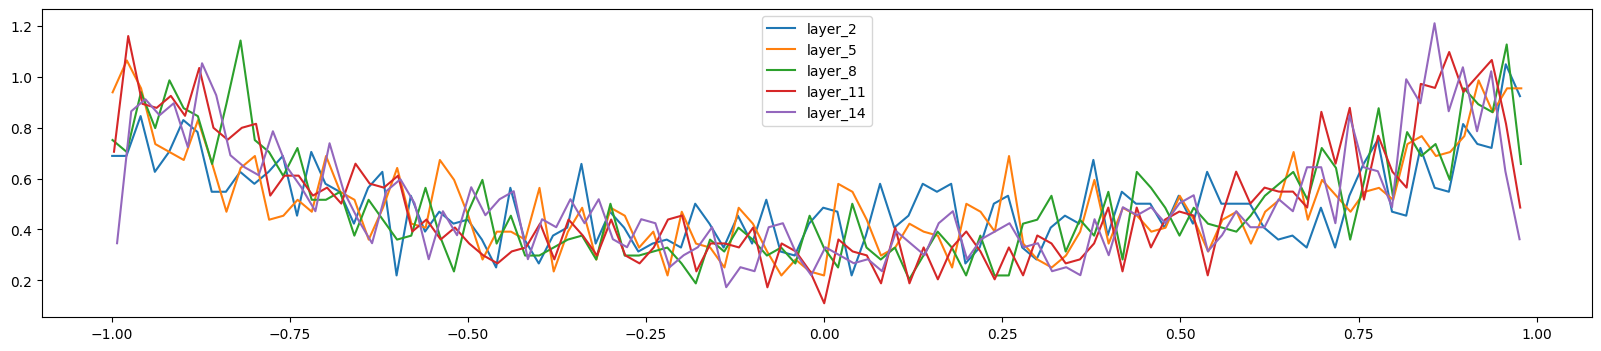

In [8]:
# plot activation
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        print(f"Layer {i}, mean {round(layer.out.mean().abs().item(), 2)}, std : {round(layer.out.std().abs().item(), 2)}, saturated : {round((layer.out.abs() > 0.97).float().mean().item() * 100, 2)}%")
        legends.append(f"layer_{i}")
        hy, hx = torch.histogram(layer.out, density=True)
        plt.plot(hx.tolist()[:-1], hy.tolist())
plt.legend(legends)

Layer 2, mean 0.0, std : 0.0034, saturated : 0.0%
Layer 5, mean 0.0, std : 0.0032, saturated : 0.0%
Layer 8, mean 0.0, std : 0.0032, saturated : 0.0%
Layer 11, mean 0.0, std : 0.0032, saturated : 0.0%
Layer 14, mean 0.0, std : 0.0037, saturated : 0.0%


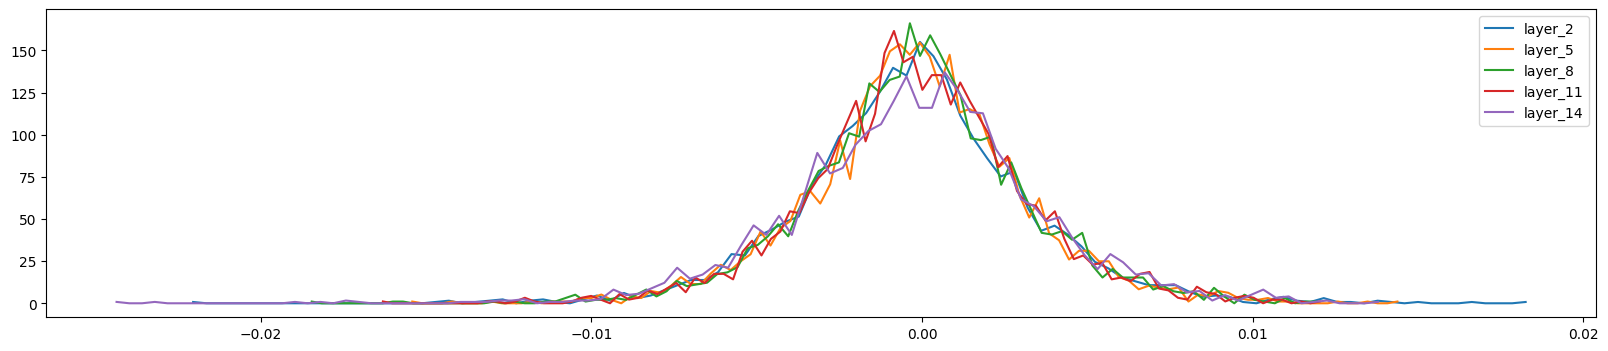

In [9]:
# plot grad of activation
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        print(f"Layer {i}, mean {round(layer.out.grad.mean().abs().item(), 4)}, std : {round(layer.out.grad.std().abs().item(), 4)}, saturated : {round((layer.out.grad.abs() > 0.97).float().mean().item() * 100, 2)}%")
        legends.append(f"layer_{i}")
        hy, hx = torch.histogram(layer.out.grad, density=True)
        plt.plot(hx.tolist()[:-1], hy.tolist())
plt.legend(legends)

layer_0, shape torch.Size([27, 10]), mean 0.1476, std 1.0968, grad:data 0.0096
layer_1, shape torch.Size([30, 100]), mean -0.0001, std 0.3121, grad:data 0.0277
layer_4, shape torch.Size([100, 100]), mean -0.0014, std 0.1802, grad:data 0.0342
layer_7, shape torch.Size([100, 100]), mean 0.0035, std 0.1794, grad:data 0.0323
layer_10, shape torch.Size([100, 100]), mean 0.0009, std 0.1781, grad:data 0.0342
layer_13, shape torch.Size([100, 100]), mean 0.0011, std 0.1763, grad:data 0.0321
layer_16, shape torch.Size([100, 27]), mean 0.0002, std 0.1213, grad:data 0.1541


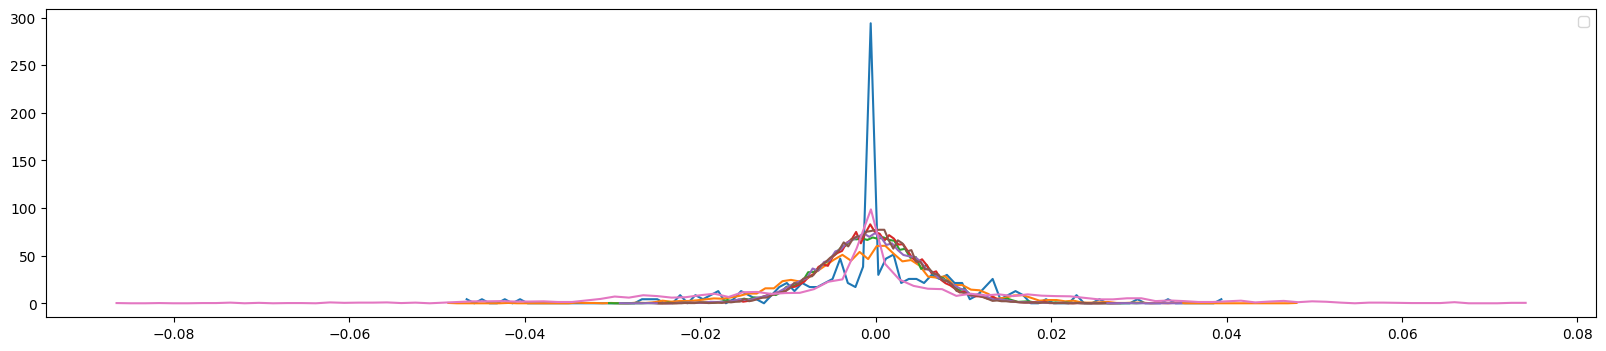

In [10]:
# plot activation / grad through time
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters[:-1]):
    if p.shape[0] > 1:
        print(f"layer_{i}, shape {p.shape}, mean {round(p.mean().item(), 4)}, std {round(p.std().item(), 4)}, grad:data {round((p.grad.std()/p.std()).item(), 4)}")
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx.tolist()[:-1], hy.tolist())
plt.legend(legends)

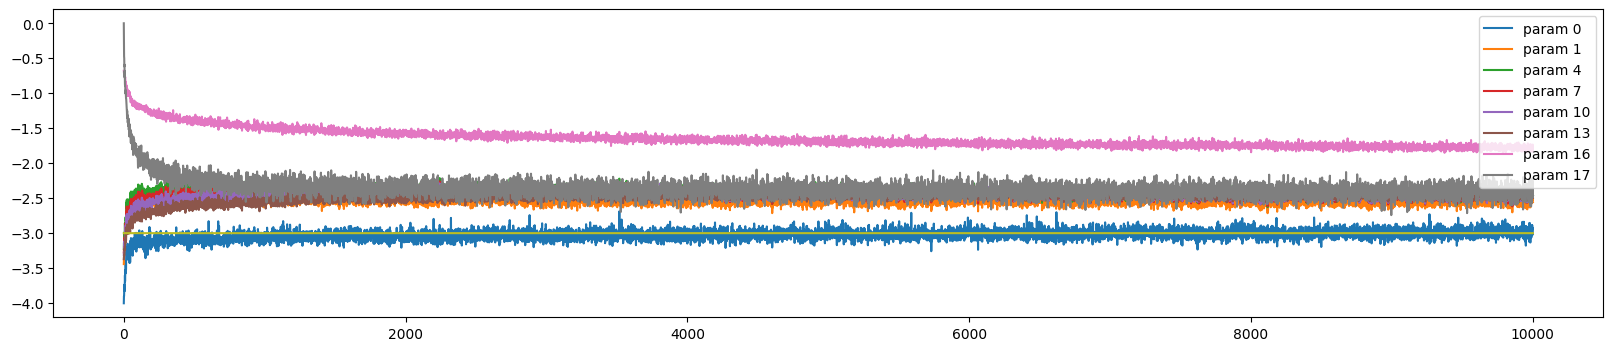

In [11]:
# plot activation / grad through time
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.shape[0] > 1:
        legends.append(f"param {i}")
        ys = [o[i] for o in ratios]
        plt.plot(range(len(ys)), ys)

plt.plot(range(len(ys)), [-3] * len(ys))
plt.legend(legends)

### Convert this file to md

In [12]:
from IPython.core.display import Javascript

In [15]:
%%js
IPython.notebook.kernel.execute('this_notebook = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [16]:
this_notebook

'2022-12-02-trigram-part3.ipynb'

In [17]:
!jupyter nbconvert --to markdown {this_notebook} --output-dir=../_posts

[NbConvertApp] Converting notebook 2022-12-02-trigram-part3.ipynb to markdown
[NbConvertApp] Support files will be in 2022-12-02-trigram-part3_files/
[NbConvertApp] Making directory ../_posts/2022-12-02-trigram-part3_files
[NbConvertApp] Making directory ../_posts/2022-12-02-trigram-part3_files
[NbConvertApp] Making directory ../_posts/2022-12-02-trigram-part3_files
[NbConvertApp] Making directory ../_posts/2022-12-02-trigram-part3_files
[NbConvertApp] Writing 9106 bytes to ../_posts/2022-12-02-trigram-part3.md
